https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

#### to load elmo to local disk:
#download the model to local so it can be used again and again
$ mkdir module/module_elmo2
# Download the module, and uncompress it to the destination folder. 
$ curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC module/module_elmo2

In [6]:
#data science
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib import pyplot as plt

#NLP
import spacy
import re

import time
from tqdm import tqdm  # progress bar

# file loading
import pickle

#deep learning
import tensorflow as tf
import tensorflow_hub as hub


In [7]:
pd.set_option('display.max_colwidth', 200)

In [9]:
# resumes only for now
# gives df with list of strings (tokenized) as well as lemmatized list of strings

ec2_resumes_path = '/home/ubuntu/NLP_projects/job_recommender_project/data/large_files/lf_cleaned_lemmatized_tokenized_resumes.csv'
ec2_pickle_resumes_path = '/home/ec2-user/NLP_projects/job_recommender_project/data/resumes_with_list_of_list.pickle'

resumes = pd.read_pickle(ec2_pickle_resumes_path)


In [10]:
resumes.head()

,ID,dirty_resume,resume,lol
0,1,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box 1673 | Callahan, FL 32011 | info@greatresumesfast.com\n\nApproachable innovator with a passion for Human Resources.\n\nSENIOR HUMAN RESOURCES PROFESS...",john h smith phr po box callahan fl infogreatresumesfastcom approachable innovator passion human resources senior human resources professional personable analytical flexible senior hr profess...,"[[john, h], [smith, phr], [po, box, callahan, fl, infogreatresumesfastcom, approachable, innovator, passion, human, resources], [senior, human, resources, professional, personable, analytical, fle..."
1,2,b'Name Surname\nAddress\nMobile No/Email\nPERSONAL PROFILE\nI am a self motivated individual who has a confident approach to people. I communicate\nwell with all levels of personnel and feel that ...,name surname address mobile noemail personal profile self motivated individual confident approach people communicate well levels personnel feel good listening ability allows resolve problems quick...,"[[name, surname, address, mobile, noemail, personal, profile, self, motivated, individual, confident, approach, people], [communicate, well, levels, personnel, feel, good, listening, ability, allo..."
2,3,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERTISE\n\nPERSONAL SUMMARY\n\nHR processes & systems\n\nA competent and organised individual who is able to work as part of a team and\nmanage several pr...,anthony brown hr assistant areas expertise personal summary hr processes systems competent organised individual able work part team manage several priorities one time anthony positive attitude str...,"[[anthony, brown, hr, assistant, areas, expertise, personal, summary, hr, processes, systems, competent, organised, individual, able, work, part, team, manage, several, priorities, one, time], [an..."
3,4,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nCareer Objective\nTo pursue a growth oriented career with a progressive company that provides a scope to apply my\nknowledge and skills that would help...,satheesh email id career objective pursue growth oriented career progressive company provides scope apply knowledge skills would help contribute best organization personal skills enjoy strong log...,"[[id, career, objective, pursue, growth, oriented, career, progressive, company, provides, scope, apply, knowledge, skills, would, help, contribute, best, organization], [personal, skills, enjoy, ..."
4,5,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert in organizational effectiveness.\n\xef\x82\xb7Recognized consensus-builder among diverse groups.\n\xef\x82\xb7Innovative problem solver.\n\xef\x82\xb...",human resources director expert organizational effectiveness recognized consensus builder among diverse groups innovative problem solver strategic partner effective executive coach facilitator man...,"[[human, resources, director, expert, organizational, effectiveness], [recognized, consensus, builder, among, diverse, groups], [innovative, problem, solver], [strategic, partner], [effective, exe..."


In [11]:
type(resumes['lol'][0][0][0])

str

In [12]:
resumes['los'] = resumes['lol']

In [13]:
len(resumes['los'][0])

35

In [14]:
for i in range (0, len(resumes['los'])):
    for j in range (0, len(resumes['los'][i])):
        resumes['los'][i][j] = ' '.join(resumes['los'][i][j])

In [15]:
resumes['los'][0][3]

'senior human resources professional personable analytical flexible senior hr professional multifaceted expertise'

In [16]:
elmo_in = resumes['los']


In [17]:
# the lenghts of each resume and resume ID for reference

for x in range(len(elmo_in)):
    print(x, ':  ', len(elmo_in[x]))

    #elmo_in[28] has 212 sentences
    #
    #elmo_in[34] has 945 sentences
    #elmo_in[75] has 3 sentences

0 :   35
1 :   9
2 :   65
3 :   63
4 :   46
5 :   35
6 :   56
7 :   76
8 :   50
9 :   4
10 :   15
11 :   32
12 :   60
13 :   33
14 :   87
15 :   65
16 :   26
17 :   7
18 :   1
19 :   31
20 :   28
21 :   31
22 :   14
23 :   36
24 :   4
25 :   24
26 :   72
27 :   15
28 :   212
29 :   15
30 :   31
31 :   69
32 :   50
33 :   41
34 :   945
35 :   29
36 :   50
37 :   6
38 :   22
39 :   15
40 :   12
41 :   64
42 :   11
43 :   22
44 :   6
45 :   12
46 :   25
47 :   6
48 :   40
49 :   8
50 :   61
51 :   10
52 :   17
53 :   17
54 :   14
55 :   32
56 :   11
57 :   17
58 :   9
59 :   26
60 :   57
61 :   20
62 :   32
63 :   3
64 :   15
65 :   3
66 :   21
67 :   28
68 :   23
69 :   70
70 :   31
71 :   30
72 :   17
73 :   92
74 :   9
75 :   3
76 :   74
77 :   32
78 :   2
79 :   68
80 :   3
81 :   30
82 :   23
83 :   26
84 :   3
85 :   18
86 :   40
87 :   153
88 :   35
89 :   61
90 :   2
91 :   20
92 :   93
93 :   1
94 :   26
95 :   42
96 :   47
97 :   42
98 :   24
99 :   100
100 :   42
101 :   45
102

984 :   41
985 :   74
986 :   17
987 :   74
988 :   22
989 :   23
990 :   74
991 :   31
992 :   398
993 :   11
994 :   30
995 :   14
996 :   20
997 :   25
998 :   9
999 :   11
1000 :   16
1001 :   15
1002 :   14
1003 :   3
1004 :   16
1005 :   196
1006 :   15
1007 :   1
1008 :   28
1009 :   23
1010 :   66
1011 :   2
1012 :   7
1013 :   12
1014 :   3
1015 :   77
1016 :   20
1017 :   30
1018 :   8
1019 :   17
1020 :   15
1021 :   25
1022 :   17
1023 :   10
1024 :   1
1025 :   26
1026 :   10
1027 :   8
1028 :   42
1029 :   31
1030 :   23
1031 :   57
1032 :   15
1033 :   45
1034 :   20
1035 :   4
1036 :   36
1037 :   40
1038 :   31
1039 :   31
1040 :   15
1041 :   2
1042 :   36
1043 :   27
1044 :   5
1045 :   6
1046 :   30
1047 :   31
1048 :   11
1049 :   7
1050 :   17
1051 :   37
1052 :   59
1053 :   146
1054 :   32
1055 :   38
1056 :   25
1057 :   53
1058 :   4
1059 :   9
1060 :   4
1061 :   28
1062 :   49
1063 :   2
1064 :   19
1065 :   4
1066 :   16
1067 :   93
1068 :   7
1069 :   29
1

In [18]:
# let's examine resume length in sentences


lengths = []
for i in range(0, len(elmo_in)):
    lengths.extend([len(elmo_in[i])])

#lengths

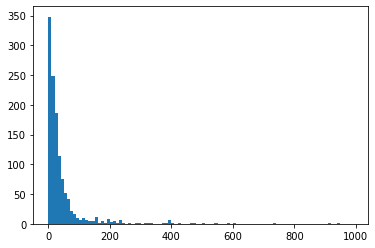

In [19]:
# let's look at distributions of resume length

plt.hist(lengths, bins=range(0, 1000, 10))

plt.show()


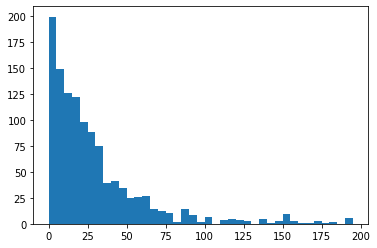

In [20]:
plt.hist(lengths, bins=range(0, 200, 5))

plt.show()

In [21]:
print("example of a short resume:")
print("resume number 244")
print("resume length: {} sentences".format(len(elmo_in[244])))
print(elmo_in[244])

example of a short resume:
resume number 244
resume length: 9 sentences
['carmen morant arbor court wheatland wy tel e mail carmenresumesamplesinfo objective experienced assistant manager looking position reputable organization', 'summary qualifications vast working experience computers windows support profound knowledge project management proficient microsoft office familiarity call center related applications ability handle multi tasks ability communicate effectively experience assistant manager present veredus corporation durham nc recommended implemented approved lanwan policies standards', 'supported office personnel corporate applications', 'created executed proper backup disaster recovery procedures', 'managed within regionally approved budget', 'maintained baseline security standard policies', 'provided solution costing rfprfq submissions system upgrades', 'educational background bachelors degree computer science mills college oakland ca gpa', 'scale']


In [22]:
print("example of a medium resume:")
print("resume number 202")
print("resume length: {} sentences".format(len(elmo_in[202])))
print(elmo_in[202])

example of a medium resume:
resume number 202
resume length: 25 sentences
['gayle laakmann apple lane philadelphia pa gaylecareercupcom education wharton school university pennsylvania philadelphia pa master business administration candidate major marketing entrepreneurship wharton ventures early stage vc fund principal one eight students selected applicants join wv sources deals performs due diligence analyzes tech healthcare investments deals k million', 'chair wharton yearbook helped launch whartons yearbook publish months', 'wharton venture capital competition finalist', 'elected social chair cohort students', 'university pennsylvania philadelphia pa master science engineering computer information science bachelor science engineering major computer science engineering minor mathematics created independently taught computer science course first undergraduate earned permission so', 'experience careercupcom seattle wa founder ceo present founded careercup help candidates prepare techn

In [23]:
print("example of a long resume:")
print("resume number 28")
print("resume length: {} sentences".format(len(elmo_in[28])))
print(elmo_in[28])

example of a long resume:
resume number 28
resume length: 212 sentences
['write professional resume xcxcresume tips following tips suggestions consider writing sending resume prospective employers use white light colored paper standard size xcxbd x inches', 'many office supply stores sell resume paper', 'sure include cover letter mailed emailed resumes', 'email resume cover letter create short introduction use email body', 'resume easy read crisp consistent format', 'always keep resume date many companies use applicant tracking systems ats scan resumes key words themes match job description', 'words identify skills company looking fill specific job postings', 'however due use software specific ways resume formatted scan properly companys system', 'use template invisible text boxes special graphics color shading', 'always use blank microsoft word document create text version resume online submissions', 'always submit resume pdf format save creative versions resume hand employer person',

In [24]:
print('min: {}'.format(np.amin(lengths)))
print('max: {}'.format(np.amax(lengths)))
print('median: {}'.format(np.median(lengths)))
print('mean: {}'.format(np.mean(lengths)))
print('stdev: {}'.format(np.std(lengths)))


min: 1
max: 1250
median: 20.0
mean: 44.66858080393765
stdev: 95.13732618693363


In [25]:
lengths_copy = lengths.copy()


In [26]:
elmo_in_smalls = elmo_in.copy()

In [27]:
elmo_in_smalls = elmo_in_smalls.tolist()

In [28]:
type(elmo_in_smalls)

list

In [29]:
for i in elmo_in_smalls:
    if len(i) > 100:
        elmo_in_smalls.remove(i)
    if len(i) <2:
        elmo_in_smalls.remove(i)

#elmo_in_smalls

In [30]:
print('[0] ',elmo_in_smalls[0])

[0]  ['john h', 'smith phr', 'po box callahan fl infogreatresumesfastcom approachable innovator passion human resources', 'senior human resources professional personable analytical flexible senior hr professional multifaceted expertise', 'seasoned benefits administrator extensive experience working highly paid professionals client relationship based settings', 'dynamic team leader capable analyzing alternatives identifying tough choices communicating total value benefit compensation packages senior level executives employees', 'core competencies benefits administration customer service cost control recruiting acquisition management compliance reporting retention professional services domestic international benefits collaboration adaptability change management defined contribution plans auditing negotiation corporate hr policies full lifecycle training k form confidential files eeo aap fmla std ltd h b visa vets eap processing payroll hr technology hris data management auditing ultipro 

In [31]:
print('[0][3] ', type(elmo_in_smalls[0][3]), len(elmo_in_smalls[0][3]), elmo_in_smalls[0][3])

[0][3]  <class 'str'> 112 senior human resources professional personable analytical flexible senior hr professional multifaceted expertise


In [32]:
for i in range(0, len(elmo_in_smalls)):
    for j in range (0, len(elmo_in_smalls[i])):
        if len(elmo_in_smalls[i][j])<2:
            print(i, j, elmo_in_smalls[i][j])



7 1 o
8 3 
8 4 
8 5 
8 6 
8 7 
8 15 
8 17 
8 25 c
8 29 f
8 41 
25 38 
30 3 
30 4 
30 5 
30 6 
30 7 
30 15 
30 17 
30 25 c
30 29 f
30 41 
33 3 
33 4 
33 5 
33 6 
33 7 
33 15 
33 17 
33 25 c
33 29 f
33 41 
43 6 
43 24 
45 39 
54 15 
59 9 
59 17 p
70 34 
70 51 
70 59 
70 68 
70 85 
85 4 
85 5 
95 33 
108 55 
119 8 j
128 2 
135 31 
156 5 
156 11 
156 18 
156 20 
156 22 
156 36 
156 39 
156 43 
156 46 
159 13 
159 63 
160 11 a
160 15 a
160 27 p
160 40 a
165 20 
167 6 
167 7 
168 16 
174 21 
174 23 
185 22 
187 6 
187 7 
188 24 
190 74 
192 42 m
201 2 
201 31 
204 3 
207 11 
212 6 
212 8 
214 12 
216 18 
217 16 
221 3 
222 5 
229 24 
233 7 
233 21 
233 22 
233 28 
233 39 
233 40 
245 1 g
254 37 
260 4 
263 21 
263 46 
263 57 
263 66 
263 82 
263 84 
263 86 
263 88 
266 5 
266 7 
266 9 
266 11 
266 13 
266 15 
266 17 
266 19 
266 31 
268 4 
274 16 
275 16 
284 2 o
288 1 
288 2 
288 3 
291 48 d
291 51 h
292 50 q
292 120 
292 122 
292 128 
292 131 
292 133 
292 139 
292 143 
292 147 
292 151 
2

In [33]:
len(elmo_in_smalls)

1088

In [34]:
lengths_smalls = []
for i in range(0, len(elmo_in_smalls)):
    lengths_smalls.extend([len(elmo_in_smalls[i])])

#lengths_smalls

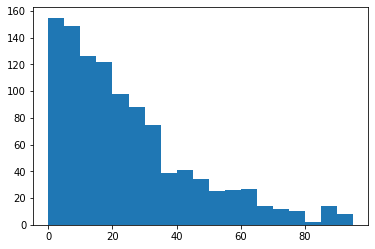

In [35]:
# let's look at distributions of resume length

plt.hist(lengths_smalls, bins=range(0, 100, 5))

plt.show()


In [36]:
# now we have lengths_smalls for each length
# now we have elmo_in_smalls for each resume

In [37]:
type(elmo_in_smalls[0])

list

In [39]:
# I have elmo saved locally
elmo = hub.Module("/home/ec2-user/module/module_elmo2", trainable=False)

# It's a Tesla V100 with a P3, K80 with P2 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [40]:
# first_try = []
# for i in range(0, len(elmo_in_smalls[0])):
#     first_try = elmo_vectors(elmo_in_smalls[0][i])
#     print(first_try)


#trying on elmo_in_smalls[0]
embeddings = elmo(elmo_in_smalls[0], signature="default",as_dict=True)["elmo"]
print("embeddings is type {} and shape {}".format(type(embeddings), embeddings.shape))
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings_2d = session.run(tf.reduce_mean(embeddings,axis=0))
    print("message_embeddings_2d is type {} and shape {}".format(type(message_embeddings_2d), message_embeddings_2d.shape))
    message_embeddings_1d = tf.reduce_mean(tf.convert_to_tensor(message_embeddings_2d), axis = 0, keepdims=True)
    print("message_embeddings_1d is type {} and shape {}".format(type(message_embeddings_1d), message_embeddings_1d.shape))


embeddings is type <class 'tensorflow.python.framework.ops.Tensor'> and shape (35, 74, 1024)
message_embeddings_2d is type <class 'numpy.ndarray'> and shape (74, 1024)
message_embeddings_1d is type <class 'tensorflow.python.framework.ops.Tensor'> and shape (1, 1024)


In [ ]:
with tf.Session() as sess:  print(message_embeddings_1d.eval()) 

In [ ]:
#trying on elmo_in_smalls[1]
embeddings1 = elmo(elmo_in_smalls[1], signature="default",as_dict=True)["elmo"]
print("embeddings is type {} and shape {}".format(type(embeddings1), embeddings1.shape))
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings1_2d = session.run(tf.reduce_mean(embeddings1,axis=0))
    print("message_embeddings1_2d is type {} and shape {}".format(type(message_embeddings1_2d), message_embeddings1_2d.shape))
    message_embeddings1_1d = session.run(tf.reduce_mean(tf.convert_to_tensor(message_embeddings1_2d), axis = 0, keepdims=True))
    print("message_embeddings1_1d is type {} and shape {}".format(type(message_embeddings1_1d), message_embeddings1_1d.shape))

    

In [ ]:
print(message_embeddings1_1d)

In [ ]:
with tf.Session() as sess:  print(message_embeddings1_1d.eval()) 

In [ ]:
with tf.Session() as sess: print(cosine_similarity(message_embeddings_1d.eval(), message_embeddings1_1d.eval()))


In [ ]:
# print("embeddings shape: {}".format(embeddings.shape))
# print("elmo_in_smalls[0] sentences: {}".format(len(elmo_in_smalls[0])))
# max_sentence_length = 0
# for i in range(0, len(elmo_in_smalls[0])):
#     if len(elmo_in_smalls[0][i].split()) > max_sentence_length:
#         max_sentence_length = len(elmo_in_smalls[0][i])
                                  
# print("elmo_in_smalls[0] max sentence length: {}".format(max_sentence_length))


In [ ]:
len(elmo_in_smalls)

In [ ]:
len(elmo_in_smalls[129])

In [ ]:
(100 % 100) == 0

In [ ]:
# for all embeddings

resume_embeddings = []


for i in tqdm(range(301, len(elmo_in_smalls))):
    # save np array of embeddings
    if i % 50 == 0:
        np_ELMo_embeddings_resumes = np.asarray(resume_embeddings)
        np.save('ELMo_embeddings_resumes_301_to_{}'.format(i), np_ELMo_embeddings_resumes) 
    
    print('elmo_in_smalls[{}]'.format(i))
    embeddings_3d = elmo(elmo_in_smalls[i], signature="default",as_dict=True)["elmo"]
#     print("embeddings is type {} and shape {}".format(type(embeddings), embeddings.shape))
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings_2d = session.run(tf.reduce_mean(embeddings_3d,axis=0))
#         print("message_embeddings_2d is type {} and shape {}".format(type(message_embeddings_2d), message_embeddings_2d.shape))
        embeddings_1d = session.run(tf.reduce_mean(tf.convert_to_tensor(embeddings_2d), axis = 0, keepdims=True))
#         print("message_embeddings_1d is type {} and shape {}".format(type(message_embeddings_1d), message_embeddings_1d.shape))
        resume_embeddings.extend(embeddings_1d)
    


    

  0%|          | 0/787 [00:00<?, ?it/s]

elmo_in_smalls[301]


  0%|          | 1/787 [00:05<1:16:17,  5.82s/it]

elmo_in_smalls[302]


  0%|          | 2/787 [00:42<3:18:30, 15.17s/it]

elmo_in_smalls[303]


  0%|          | 3/787 [00:53<2:59:04, 13.70s/it]

elmo_in_smalls[304]


  1%|          | 4/787 [01:03<2:45:37, 12.69s/it]

elmo_in_smalls[305]


  1%|          | 5/787 [01:06<2:09:08,  9.91s/it]

elmo_in_smalls[306]


  1%|          | 6/787 [01:10<1:43:46,  7.97s/it]

elmo_in_smalls[307]


  1%|          | 7/787 [01:13<1:25:20,  6.57s/it]

elmo_in_smalls[308]


  1%|          | 8/787 [01:19<1:24:16,  6.49s/it]

elmo_in_smalls[309]


  1%|          | 9/787 [01:28<1:33:58,  7.25s/it]

elmo_in_smalls[310]


  1%|▏         | 10/787 [01:37<1:37:18,  7.51s/it]

elmo_in_smalls[311]


  1%|▏         | 11/787 [01:41<1:24:00,  6.50s/it]

elmo_in_smalls[312]


  2%|▏         | 12/787 [01:48<1:26:01,  6.66s/it]

elmo_in_smalls[313]


  2%|▏         | 13/787 [03:13<6:29:25, 30.19s/it]

elmo_in_smalls[314]


  2%|▏         | 14/787 [03:22<5:06:18, 23.78s/it]

elmo_in_smalls[315]


  2%|▏         | 15/787 [03:28<3:57:26, 18.45s/it]

elmo_in_smalls[316]


  2%|▏         | 16/787 [03:36<3:17:11, 15.35s/it]

elmo_in_smalls[317]


  2%|▏         | 17/787 [03:43<2:47:39, 13.06s/it]

elmo_in_smalls[318]


  2%|▏         | 18/787 [03:54<2:37:39, 12.30s/it]

elmo_in_smalls[319]


  2%|▏         | 19/787 [04:38<4:40:47, 21.94s/it]

elmo_in_smalls[320]


  3%|▎         | 20/787 [04:46<3:43:33, 17.49s/it]

elmo_in_smalls[321]


  3%|▎         | 21/787 [04:57<3:21:59, 15.82s/it]

elmo_in_smalls[322]


  3%|▎         | 22/787 [05:05<2:51:46, 13.47s/it]

elmo_in_smalls[323]


  3%|▎         | 23/787 [05:17<2:45:21, 12.99s/it]

elmo_in_smalls[324]


  3%|▎         | 24/787 [05:25<2:23:25, 11.28s/it]

elmo_in_smalls[325]


  3%|▎         | 25/787 [05:36<2:22:45, 11.24s/it]

elmo_in_smalls[326]


  3%|▎         | 26/787 [05:45<2:14:28, 10.60s/it]

elmo_in_smalls[327]


  3%|▎         | 27/787 [05:57<2:18:15, 10.92s/it]

elmo_in_smalls[328]


  4%|▎         | 28/787 [06:06<2:13:24, 10.55s/it]

elmo_in_smalls[329]


  4%|▎         | 29/787 [06:16<2:10:40, 10.34s/it]

elmo_in_smalls[330]


  4%|▍         | 30/787 [06:27<2:11:22, 10.41s/it]

elmo_in_smalls[331]


  4%|▍         | 31/787 [06:38<2:15:08, 10.73s/it]

elmo_in_smalls[332]


  4%|▍         | 32/787 [06:51<2:23:35, 11.41s/it]

elmo_in_smalls[333]


  4%|▍         | 33/787 [07:02<2:19:43, 11.12s/it]

elmo_in_smalls[334]


  4%|▍         | 34/787 [07:18<2:40:58, 12.83s/it]

elmo_in_smalls[335]


  4%|▍         | 35/787 [07:33<2:46:54, 13.32s/it]

elmo_in_smalls[336]


  5%|▍         | 36/787 [07:45<2:42:23, 12.97s/it]

elmo_in_smalls[337]


  5%|▍         | 37/787 [07:57<2:37:51, 12.63s/it]

elmo_in_smalls[338]


  5%|▍         | 38/787 [08:12<2:45:45, 13.28s/it]

elmo_in_smalls[339]


  5%|▍         | 39/787 [08:27<2:51:57, 13.79s/it]

elmo_in_smalls[340]


  5%|▌         | 40/787 [08:42<2:56:19, 14.16s/it]

elmo_in_smalls[341]


  5%|▌         | 41/787 [08:57<3:01:02, 14.56s/it]

elmo_in_smalls[342]


  5%|▌         | 42/787 [09:12<3:01:51, 14.65s/it]

elmo_in_smalls[343]


  5%|▌         | 43/787 [09:28<3:06:01, 15.00s/it]

elmo_in_smalls[344]


  6%|▌         | 44/787 [09:41<2:59:31, 14.50s/it]

elmo_in_smalls[345]


  6%|▌         | 45/787 [10:01<3:18:49, 16.08s/it]

elmo_in_smalls[346]


  6%|▌         | 46/787 [10:16<3:13:57, 15.71s/it]

elmo_in_smalls[347]


  6%|▌         | 47/787 [10:34<3:24:22, 16.57s/it]

elmo_in_smalls[348]


  6%|▌         | 48/787 [10:53<3:33:15, 17.31s/it]

elmo_in_smalls[349]


  6%|▌         | 49/787 [11:09<3:27:47, 16.89s/it]

elmo_in_smalls[350]


  6%|▋         | 50/787 [11:24<3:18:54, 16.19s/it]

elmo_in_smalls[351]


  6%|▋         | 51/787 [12:20<5:44:15, 28.06s/it]

elmo_in_smalls[352]


  7%|▋         | 52/787 [12:55<6:12:28, 30.41s/it]

elmo_in_smalls[353]


  7%|▋         | 53/787 [13:14<5:27:35, 26.78s/it]

elmo_in_smalls[354]


  7%|▋         | 54/787 [13:31<4:52:14, 23.92s/it]

elmo_in_smalls[355]


  7%|▋         | 55/787 [13:58<5:03:31, 24.88s/it]

elmo_in_smalls[356]


  7%|▋         | 56/787 [14:16<4:37:15, 22.76s/it]

elmo_in_smalls[357]


  7%|▋         | 57/787 [14:34<4:21:30, 21.49s/it]

elmo_in_smalls[358]


  7%|▋         | 58/787 [14:56<4:23:01, 21.65s/it]

elmo_in_smalls[359]


  7%|▋         | 59/787 [15:34<5:20:45, 26.44s/it]

elmo_in_smalls[360]


  8%|▊         | 60/787 [15:54<4:57:18, 24.54s/it]

elmo_in_smalls[361]


  8%|▊         | 61/787 [16:12<4:33:34, 22.61s/it]

elmo_in_smalls[362]


  8%|▊         | 62/787 [16:32<4:22:06, 21.69s/it]

elmo_in_smalls[363]


  8%|▊         | 63/787 [16:51<4:13:37, 21.02s/it]

elmo_in_smalls[364]


  8%|▊         | 64/787 [17:12<4:12:31, 20.96s/it]

elmo_in_smalls[365]


  8%|▊         | 65/787 [17:31<4:05:43, 20.42s/it]

elmo_in_smalls[366]


  8%|▊         | 66/787 [17:53<4:11:29, 20.93s/it]

elmo_in_smalls[367]


  9%|▊         | 67/787 [18:14<4:08:24, 20.70s/it]

elmo_in_smalls[368]


  9%|▊         | 68/787 [18:36<4:13:55, 21.19s/it]

elmo_in_smalls[369]


  9%|▉         | 69/787 [19:07<4:48:00, 24.07s/it]

elmo_in_smalls[370]


  9%|▉         | 70/787 [19:28<4:37:22, 23.21s/it]

elmo_in_smalls[371]


  9%|▉         | 71/787 [19:48<4:24:55, 22.20s/it]

elmo_in_smalls[372]


  9%|▉         | 72/787 [20:08<4:19:02, 21.74s/it]

elmo_in_smalls[373]


  9%|▉         | 73/787 [20:35<4:35:58, 23.19s/it]

elmo_in_smalls[374]


  9%|▉         | 74/787 [21:02<4:49:12, 24.34s/it]

elmo_in_smalls[375]


 10%|▉         | 75/787 [21:24<4:39:02, 23.52s/it]

elmo_in_smalls[376]


 10%|▉         | 76/787 [22:02<5:31:10, 27.95s/it]

elmo_in_smalls[377]


 10%|▉         | 77/787 [22:42<6:14:54, 31.68s/it]

elmo_in_smalls[378]


 10%|▉         | 78/787 [23:04<5:39:41, 28.75s/it]

elmo_in_smalls[379]


 10%|█         | 79/787 [23:33<5:39:52, 28.80s/it]

elmo_in_smalls[380]


 10%|█         | 80/787 [23:57<5:22:05, 27.34s/it]

elmo_in_smalls[381]


 10%|█         | 81/787 [24:27<5:30:00, 28.05s/it]

elmo_in_smalls[382]


 10%|█         | 82/787 [24:50<5:13:33, 26.69s/it]

elmo_in_smalls[383]


 11%|█         | 83/787 [25:14<5:03:53, 25.90s/it]

elmo_in_smalls[384]


 11%|█         | 84/787 [25:38<4:54:12, 25.11s/it]

elmo_in_smalls[385]


 11%|█         | 85/787 [26:11<5:21:39, 27.49s/it]

elmo_in_smalls[386]


 11%|█         | 86/787 [26:34<5:07:19, 26.30s/it]

elmo_in_smalls[387]


 11%|█         | 87/787 [27:00<5:04:47, 26.12s/it]

elmo_in_smalls[388]


 11%|█         | 88/787 [27:26<5:04:00, 26.09s/it]

elmo_in_smalls[389]


 11%|█▏        | 89/787 [27:50<4:56:03, 25.45s/it]

elmo_in_smalls[390]


 11%|█▏        | 90/787 [28:26<5:33:59, 28.75s/it]

elmo_in_smalls[391]


 12%|█▏        | 91/787 [28:52<5:23:03, 27.85s/it]

elmo_in_smalls[392]


 12%|█▏        | 92/787 [29:18<5:14:57, 27.19s/it]

elmo_in_smalls[393]


 12%|█▏        | 93/787 [29:43<5:09:30, 26.76s/it]

elmo_in_smalls[394]


 12%|█▏        | 94/787 [30:11<5:11:12, 26.94s/it]

elmo_in_smalls[395]


 12%|█▏        | 95/787 [30:39<5:13:24, 27.17s/it]

elmo_in_smalls[396]


 12%|█▏        | 96/787 [31:04<5:07:18, 26.68s/it]

elmo_in_smalls[397]


 12%|█▏        | 97/787 [31:31<5:07:45, 26.76s/it]

elmo_in_smalls[398]


 12%|█▏        | 98/787 [32:13<5:59:47, 31.33s/it]

elmo_in_smalls[399]


 13%|█▎        | 99/787 [32:41<5:47:21, 30.29s/it]

elmo_in_smalls[400]


 13%|█▎        | 100/787 [33:11<5:45:58, 30.22s/it]

elmo_in_smalls[401]


 13%|█▎        | 101/787 [33:42<5:49:06, 30.53s/it]

elmo_in_smalls[402]


In [ ]:
# save elmo in smalls
np_elmo_in_smalls = np.asarray(elmo_in_smalls)
np.save('ELMo_embeddings_resumes, np_elmo_in_smalls) 

In [ ]:
# save np array of embeddings
np_ELMo_embeddings_resumes = np.asarray(resume_embeddings)
np.save('ELMo_embeddings_resumes_301_{}'.format(len(elmo_in_smalls)', np_ELMo_embeddings_resumes) 

In [ ]:
# save elmo_train_new
pickle_out = open("ELMo_embeddings_resumes.pickle","wb")
pickle.dump(np_ELMo_embeddings_resumes, pickle_out)
pickle_out.close()

# ========================================